In [3]:
# Load all the libraries needed for running this notebook
library(tidyverse)
library(repr)
library(ggplot2)
library(tidymodels)
options(repr.matrix.max.rows = 4) #limits output of dataframes to 4 rows

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Harnessing KNN Classification to Predict Newsletter Subscription Status among Minecraft Server Users

**INTRODUCTION**

A research group in the Department of UBC Computer Science has been running a Minecraft server to collect player data, and this project aims to create a model to aid in their recruitment efforts. The Minecraft server has collected several data points that are categorical, logical, and numerical. This data tracks how users interact with the Minecraft server, which is crucial for targeting efforts, similar to how user data is sold on the internet to companies for better ad targeting.

The broader research question guiding this project is: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? The specific question we aim to answer is: Can the total number of hours played and user age predict whether an individual will subscribe to the newsletter, using the `players.csv` dataset?

Because the outcome variable indicates whether a player subscribed or not, the task involves classifying players based on behavioural characteristics rather than predicting a continuous outcome. Understanding which traits are most associated with newsletter engagement can reveal patterns of player behaviour and inform future recruitment strategies.

The `players.csv` dataset contains seven variables. There are four categorical variables: `experience,` `hashedEmail,` `name,` and `gender.` There is one logical variable that will act as the outcome variable, which will serve as the outcome variable in our model: `Subscription.` Additionally, two numerical variables will be crucial to the project: `age` and `played_hours,` which will be our predictor variables.

**Data Loading**

We begin by loading the `players` dataset from the course GitHub repository. This dataset contains one row per player on the Minecraft server, including demographic information, play time, and a boolean variable indicating whether the player is subscribed to the newsletter. We use `read_csv()` to import the data directly from its URL so that the analysis is fully reproducible without any local files.

Below is a snippet of the dataset which has been loaded into R:

In [5]:
library(tidyverse)
library(repr)

players <- read_csv("https://raw.githubusercontent.com/Aylin-Ab/dsci100-2025w1-group27/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Data Description**:

Above, we see the data loaded into R using read_csv. Here is an explanation of the variables for a quick overview of the players data set:

| Variable            | Description                                                                                                                                                        |
| ------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| hashedEmail         | These strings of characters are encrypted email addresses that undergo "hashing" to make them secure                                                            
| experience          | Classifies the user based on how much experience they have playing the game as "veteran," "regular," or "amateur"                                                  |
| subscribe           | Logical variable that states whether or not the user has subscribed to the game-related newsletter                                                                 |
| played_hours        | Total amount of hours that the user has logged on the server                                                                                                       |
| name                | User name                                                                                                                                                          |
| gender              | User gender                                                                                                                                                        |
| age                 | User age                                                                                                                                                           |



Below are Summary Statistics summarizing the number of items each variable has, as well as other key metrics like the minimum, mean, and maximum for numeric values.

In [6]:
players |> summary(across(round(hashed_Email: Age), 3))


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

This summary shows us key metrics of the `players` data set. The variables have their own columns, and observations have
their own rows, and each value has its own cell, meaning this data set is tidy. 

## Methods and Results

In this section, we describe our analysis workflow, from loading and cleaning the raw player data to training and evaluating a k-nearest neighbour (KNN) classifier. All code is written in R using the tidyverse and tidymodels packages. Our goal is to use two simple behavioural features, player age and total played hours on the server, to predict whether a player has subscribed to the game-related newsletter. Before developing the model, we explored the data visually to identify potential trends.

**Exploratory Data Visualization**

Before building our predictive model, we first examined simple relationships within the dataset to understand potential patterns. Figure 1 visualizes the mean number of hours played for each age group. To create it, we grouped the data by Age and calculated the mean of played_hours, then plotted these values using ggplot2. This exploratory plot helps identify whether playtime systematically varies with player age, which could influence our modeling choices.

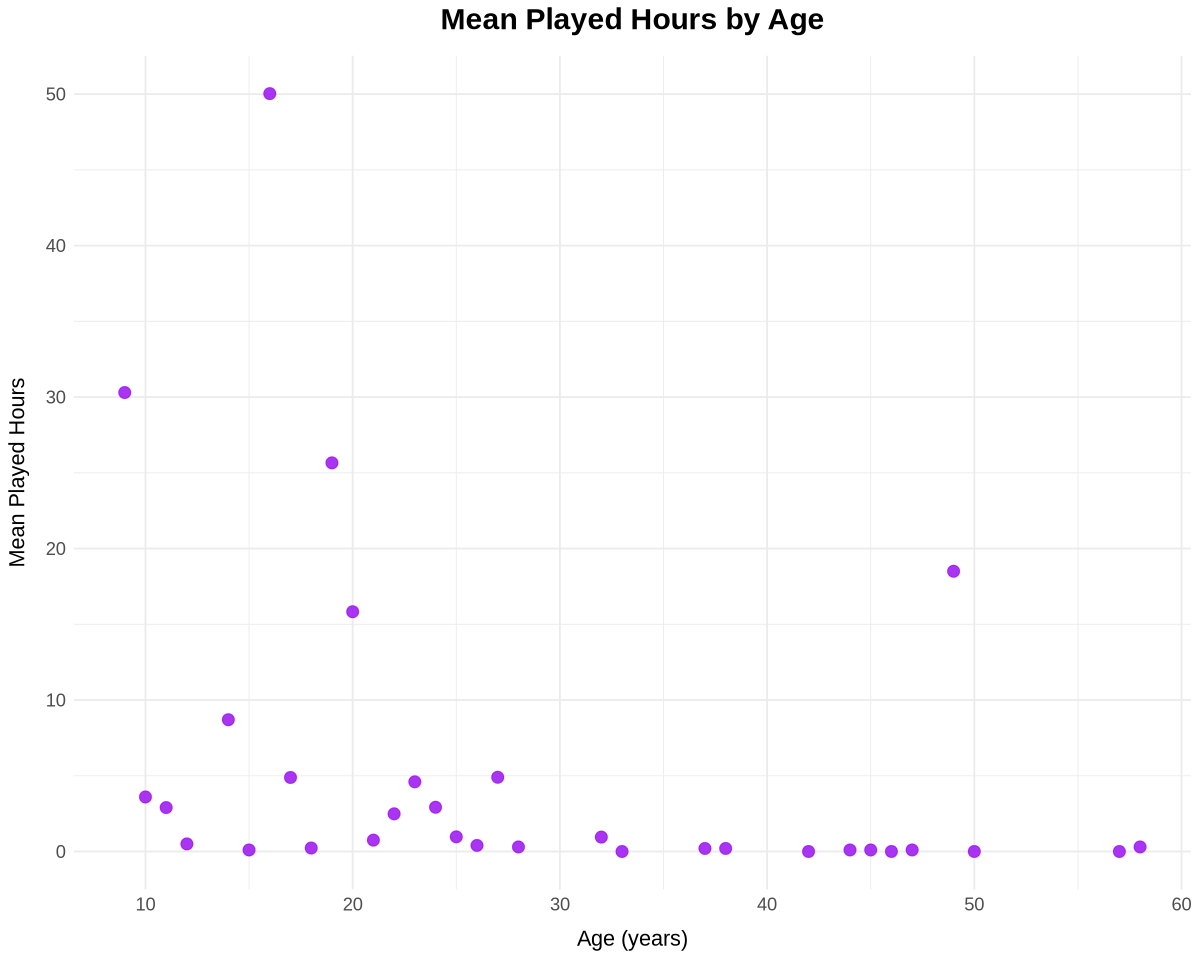

In [22]:
age_means  <- players |>
  group_by(Age) |>
  summarise(mean_played_hours = mean(played_hours, na.rm = TRUE))


ggplot(age_means, na.rm = TRUE, aes(x = Age, y = mean_played_hours)) +
  geom_point(color = "purple", size = 3, alpha = 0.9) +
  labs(
    title = "Mean Played Hours by Age",
    x = "Age (years)",
    y = "Mean Played Hours") +
    theme_minimal() +
    theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5, margin = margin(b = 12)),
    axis.title = element_text(size = 13),
    axis.text = element_text(size = 11),
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.title.y = element_text(margin = margin(r = 10)))

**Figure 1.** Mean played hours by age. The plot shows that there is no strong relationship between a player's age and the average amount of hours spent on the server. 

Broad Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Question: Can the total number of hours played predict whether an individual will subscribe to the newsletter, using the "players" data set?

**Exploratory Data Visualization**

To explore how these variables interact, we next visualized both predictors together, age and total hours played, while distinguishing players by their subscription status. Figure 2 provides a clearer view of whether certain age groups or playtime levels correspond to a higher likelihood of subscribing, offering an early visual sense of class separation before any modeling is performed.

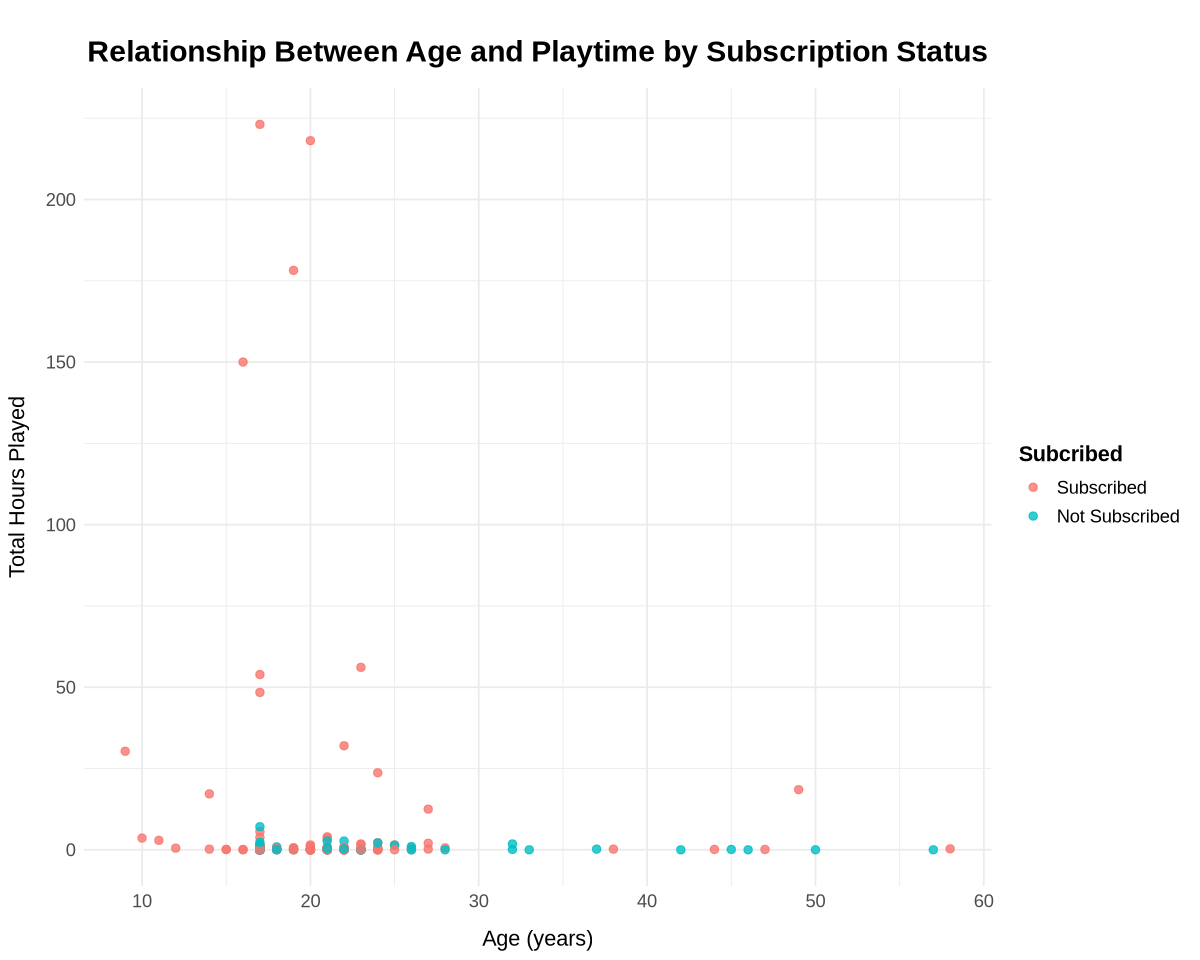

In [21]:
ggplot(players, na.rm = TRUE, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point( size = 2, alpha = 0.8) +
  labs(
    title = "
Relationship Between Age and Playtime by Subscription Status",
    x = "Age (years)",
    y = "Total Hours Played", color = "Subcribed") +
    theme_minimal() +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5, margin = margin(b = 12)),
    axis.title.x = element_text(size = 13, margin = margin(t = 12)),
    axis.title.y = element_text(size = 13, margin = margin(r = 10)),
    axis.text = element_text(size = 11),
    legend.title = element_text(size = 13, face = "bold"),
    legend.text = element_text(size = 11))

**Figure 2.** Age versus played hours coloured by subscription status.

The data visualisation above allows us to see that no one who played more than ~15 hours on the server subscribed to the newsletter, indicating a possible relationship between total hours played and whether a user was subscribed to the game-related newsletter. To create a model, we must see that the data is not continuous, as our response variable is a logical True or False, and not something that can be modelled linearly. Because of this, we would not want to use linear regression as the data does not present itself in a linear fashion, and does not have a continuous outcome. Similarly, we would not want to use KNN Regression because the outcome is not a continuous numerical value. 

For this kind of data, we would want to create a model using KNN Classification, which does not require continuous data, and can operate with classification outcomes like True or False in this case. With the right tuning and the use of cross-validation, we can use KNN classification to find the optimal amount of *K* neighbours, to be able to predict whether or not a player is likely to be subscribed to the newsletter based on how much of hours they have logged on the server. 

To accomplish this, we will only be using the `players` data set, then we will split the data into training and testing splits with an 80:20 training: testing ratio using prop and strata. We will then create a recipe using `played_hours` as our predictor with our training data, ensuring our data is scaled because KNN classification uses distance. We will then perform a five-fold cross-validation, followed by a workflow analysis using *K* values ranging from 1-20. Testing a range of k values allows us to find the point where the classifier best balances bias and variance. Small k values may overfit, while large ones may oversmooth the decision boundary. We will then use the metrics function to find the best *K* for this model. This ideal *K* value will be used to fit our model so that we can predict unknown data points. 

A limitation to this model would be that the cross-validation of 20 *K* predictors is extremely intensive and may need to be altered to be less straining on the server. Furthermore, KNN Classification does not fit an exact model like linear regression (which has distinct coefficients), so it may be hard to see what variable is truly the most predictive of an outcome. 

## Wrangling & Modeling

**Data cleaning and feature selection**

For our prediction task, we will focus on `Age`, `played_hours`, and `subscribe`. We convert `subscribe` to a factor with labels `"Subscribed"` and `"Not Subscribed"`, and remove any rows with missing values in these variables using `na.omit()`. This gives us a clean dataset for modelling.

In [9]:
#  Convert subscribe column into a factor (TRUE = Subscribed, FALSE = Not Subscribe)
players <- players |>
    mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE), labels = c("Subscribed", "Not Subscribed")))


# remove NA values in any columns of the dataframe
players <- players |>
    na.omit()

players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,Not Subscribed,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,Not Subscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


**Train-test split**

We split the cleaned data into an 80% training set and a 20% test set using `initial_split()` with stratification on `subscribe`. This preserves the class balance in both sets and allows us to evaluate how well the model generalises to unseen players.


In [10]:
# split players into training and testing set, using an 80:20 split ratio
players_split <- initial_split(players, prop = 0.8 , strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

**KNN model and hyperparameter tuning**

We use a k-nearest neighbour (KNN) classifier with `Age` and `played_hours` as predictors. Because KNN is distance-based, we standardise both predictors using a tidymodels recipe with `step_scale()` and `step_center()`. The number of neighbours *k* is tuned with 5-fold cross-validation on the training set by evaluating accuracy over a grid of candidate values.


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.7469892,5,0.0104909,Preprocessor1_Model17


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


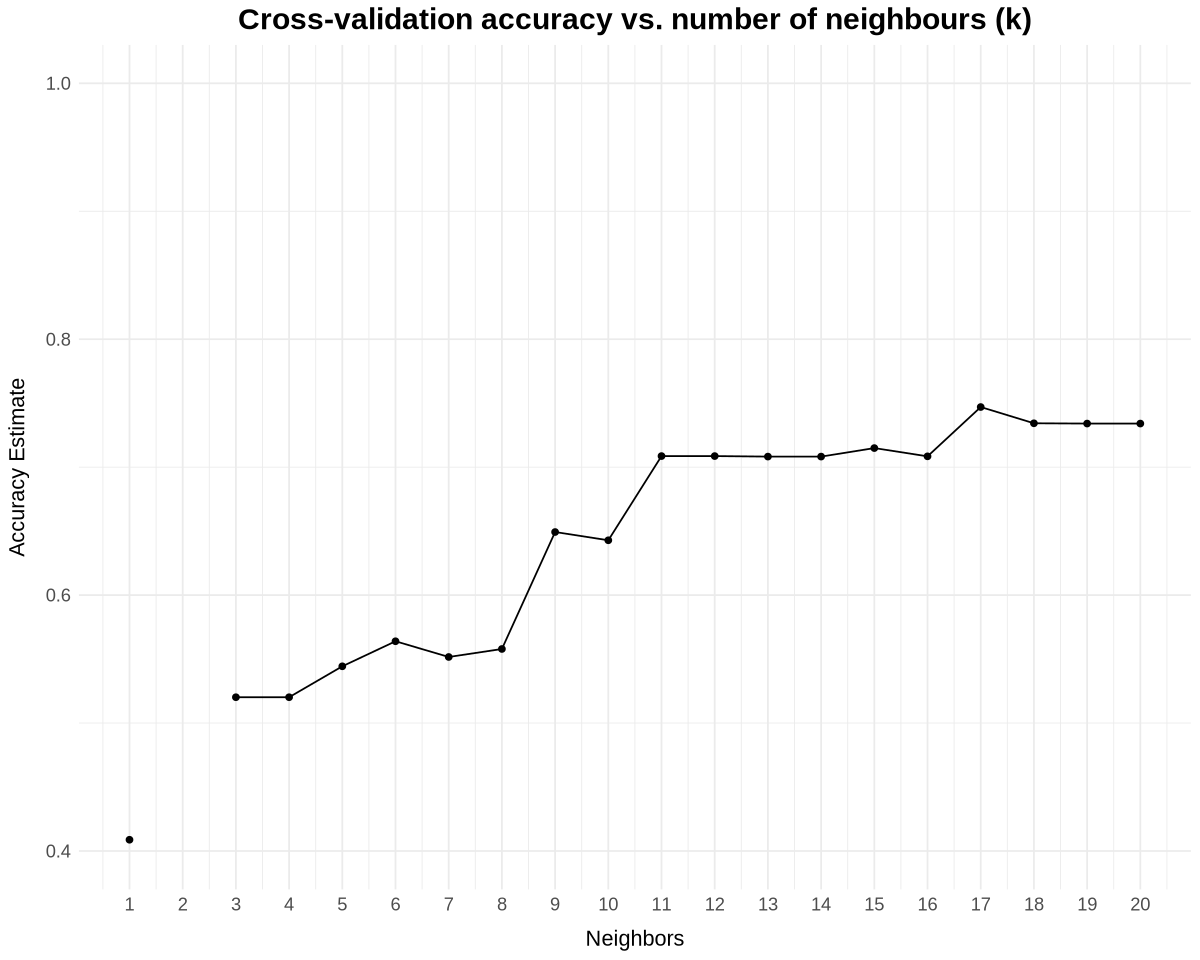

In [20]:
set.seed(1234) 
# perform tuning and cross-validation to select the best k with highest accuracy

# set knn model specification to tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# specifiy the number of folds for cross-validation
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# create a recipe to be used for cross-validation & tuning
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a vector with all k values we want to perform tuning on
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# create a workflow that combines the recipe and knn_tune model spec, and collect the accuray metric for each k
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

# select the k value with highest level of accuracy
accuracies <- knn_results |>
    filter(.metric == "accuracy") 


accuracie_max <- accuracies |>
    slice_max(mean)
accuracie_max

options(repr.plot.width = 10, repr.plot.height = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Cross-validation accuracy vs. number of neighbours (k)") +
    scale_x_continuous(breaks = seq(0, 60, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
    theme_minimal() +
    theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 13, margin = margin(t = 10)),  
    axis.title.y = element_text(size = 13, margin = margin(r = 10)),
    axis.text = element_text(size = 11))

cross_val_plot

**Figure 3.** Cross-validated accuracy of the KNN classifier for different numbers of neighbours. The chosen value of *k* corresponds to the highest accuracy and balances overfitting and underfitting. The plot shows how the model’s predictive accuracy changes as *k* increases from 1 to 20. Accuracy improves rapidly between *k* = 1 and *k* = 10, after which the curve begins to flatten, indicating diminishing returns. The highest accuracy occurs around *k* = 17, which will be selected for the final model. This value balances model complexity and generalisation: smaller *k* values risk overfitting to local noise, while larger *k* values smooth the decision boundary and may underfit the data.

**Final model and evaluation**

Using the best value of *k* from cross-validation (*k* = 17), we fit a final KNN model on the full training set. We then predict subscription status for the held-out test set and compute accuracy and a confusion matrix to assess performance.


In [12]:
# train the model on the training set using the best value of k obtained from tuning

set.seed(1234) 
# create a model spec with the best value of k 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit the model on the training set
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

In [13]:
# conduct prediction on the dataset
set.seed(1234) 

players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)
players_predictions 

players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
players_metrics

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Subscribed,Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Subscribed,Veteran,Not Subscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Subscribed,Amateur,Subscribed,24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,32.0,Sidney,Male,22
Subscribed,Amateur,Not Subscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70000000
kap,binary,-0.04803493


In [14]:
# Create a confusion matrix to evaluate the performance of the model
players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat 

                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             28             11
  Not Subscribed          1              0

**Figure 4.** Confusion matrix for the final KNN model on the test set. The diagonal cells show correct classifications (28 players correctly identified as subscribed, none as not subscribed), while the off-diagonal cells represent errors (11 false positives and 1 false negative). The results show that the model tends to over-predict the “Subscribed” class, consistent with its 70% accuracy value.

## Discussion

In this project, we used a k-nearest neighbour (KNN) classifier with two predictors, `Age` and `played_hours`, to predict whether a player was subscribed to a game-related newsletter. After tuning the number of neighbours using five-fold cross-validation, we found that the best value of *k* (*k* = 17) gave a model accuracy of about 70% on the test set. In other words, using only age and total time spent on the server, the model correctly predicted a player’s subscription status around seven times out of ten. The confusion matrix also showed that the model tends to predict “Subscribed” much more often, which explains why the accuracy is moderate rather than high.

These results mostly align with what we expected. Players who spent more time on the server were more likely to be subscribed, and those with very low play time rarely subscribed. However, the relationship is not as strong as we might have thought. Age and total play time clearly matter, but they do not fully explain subscription behaviour. Other factors, such as how often players log in, what time of day they play, or how socially active they are on the server, could all influence whether they decide to subscribe to the newsletter.

While the model performs reasonably well, accuracy alone does not give the full picture. If one group (for example, non-subscribers) is much larger than the other, a model can appear accurate just by predicting the majority most of the time. Future versions of this analysis could include additional metrics such as precision and recall to better understand how well the model identifies true subscribers and avoids false predictions.

The simplicity of KNN also limits interpretability. Unlike regression models, KNN does not show how strongly each variable influences the outcome; it only looks at the distance between points. As datasets grow larger, KNN can also become slower to compute because every prediction must compare against all existing data. Trying other models, such as regression, could improve interpretability and performance.

Even with its limits, this project shows how a simple model can showcase interesting behavioural patterns. Players with high engagement but no subscription could be targeted with reminders or incentives, helping the research group tailor outreach more effectively. In the future, expanding the dataset to include more variables or data from other servers could make the findings more generalizable. Overall, our analysis shows that while KNN is a simple approach, it can still reveal meaningful trends about player behaviour and open up new questions for further research.